This file takes a look at various max drawdown calculations to get a better understanding of why we get a value less than -100% in our riskfolio analysis for max drawdown. 

In [15]:
import pandas as pd
import numpy as np
import riskfolio as rp
import yfinance as yf
import matplotlib.pyplot as plt
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [16]:
#Read in data and set index as the date
df = pd.read_csv('yf_df.csv')
df.set_index('Date', inplace = True)
df.index = pd.to_datetime(df.index)
df


,BTC,ETH,XRP,DOGE,LINK
Date,,,,,
2020-05-11,8601.795898,185.912842,0.194064,0.002413,3.585065
2020-05-12,8804.477539,189.312500,0.197637,0.002463,3.692374
2020-05-13,9269.987305,199.193283,0.201480,0.002521,3.760424
2020-05-14,9733.721680,202.949097,0.203129,0.002574,3.799387
2020-05-15,9328.197266,195.622665,0.198911,0.002506,3.674653
...,...,...,...,...,...
2024-05-24,68526.101562,3726.934570,0.535753,0.163803,17.247709
2024-05-25,69265.945312,3749.236572,0.541809,0.173960,17.441204
2024-05-26,68518.093750,3825.897461,0.528211,0.166220,17.046471


In [17]:
#Get returns
returns = df.pct_change().dropna() #Overall returns for each asset

In [18]:
#Building portfolio object
port = rp.Portfolio(returns, nea = 4) #Number of Effective Assets (NEA)

port.assets_stats(
    method_mu = 'hist', #Selected method to estimate expected returns based on historical data
    method_cov = 'hist', #Selected method to estimate covariance matrix based on historical data
    d = 0.94)

#Estimate optimal portfolio for mean/cvar ratio
w = port.optimization(
    model = 'Classic', #Either classic, BL(Black Litterman), FM(Factor model), BLFM(Black Litterman w/Factor models)
    rm = 'CVaR', #Risk measure
    obj = 'Sharpe', #Objective function, could be MinRisk, MaxRet, Utility or Sharpe
    hist = True, #Use historical scenarios for risk measures
    rf = 0, #Risk free rate
    l = 0) #Risk aversion factor, only useful when obj is 'utility'
w #Optimal weights for our portfolio

,weights
BTC,0.180017
ETH,0.198808
XRP,0.138580
DOGE,0.386927
LINK,0.095668


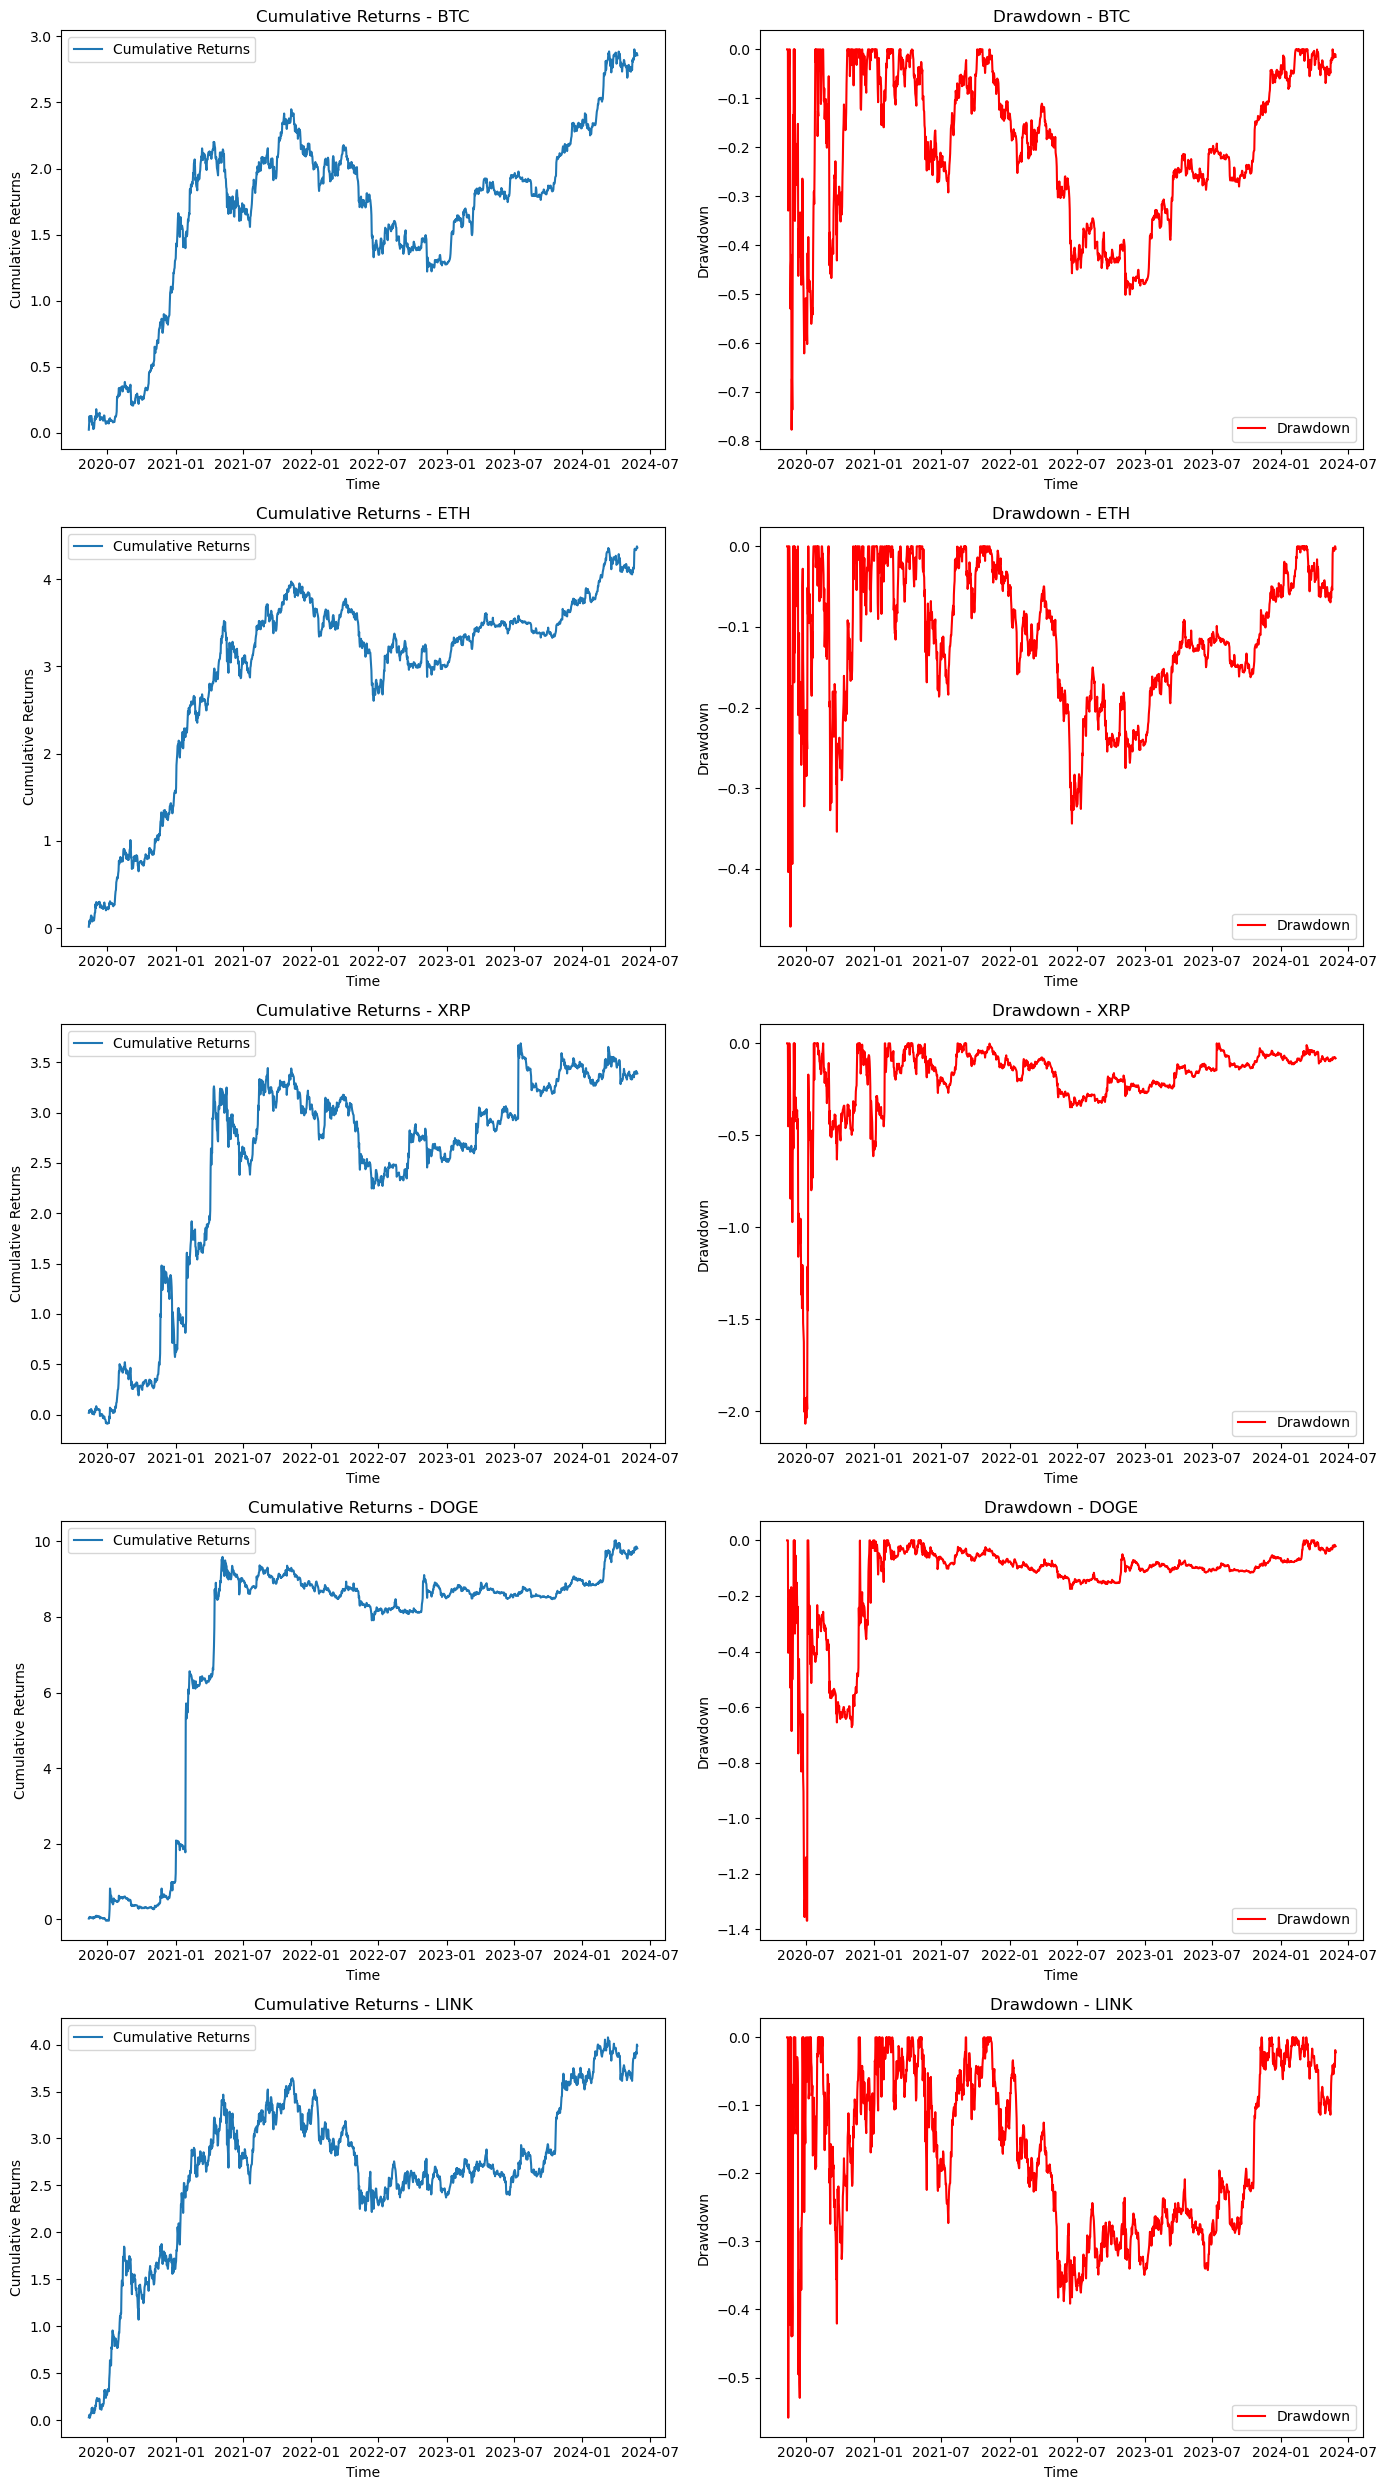

In [19]:
#Checking max draw down using my own formula

def plot_cumulative_returns_and_drawdown(returns):
    # Number of assets
    num_assets = len(returns.columns)  # All columns represent assets

    # Create subplots
    fig, axes = plt.subplots(num_assets, 2, figsize=(14, 5 * num_assets))

    for i, column in enumerate(returns.columns):  # Iterate over each asset
        asset_returns = returns[column]
        
        # Calculate cumulative returns
        cumulative_returns = np.cumsum(asset_returns)
        
        # Calculate peak returns
        peak = np.maximum.accumulate(cumulative_returns)
        
        # Calculate drawdown
        drawdown = (cumulative_returns - peak) / peak
        
        # Plot cumulative returns
        axes[i, 0].plot(cumulative_returns, label='Cumulative Returns')
        axes[i, 0].set_title(f'Cumulative Returns - {column}')
        axes[i, 0].set_xlabel('Time')
        axes[i, 0].set_ylabel('Cumulative Returns')
        axes[i, 0].legend()

        # Plot drawdown
        axes[i, 1].plot(drawdown, label='Drawdown', color='red')
        axes[i, 1].set_title(f'Drawdown - {column}')
        axes[i, 1].set_xlabel('Time')
        axes[i, 1].set_ylabel('Drawdown')
        axes[i, 1].legend()

    plt.tight_layout()
    plt.show()

plot_cumulative_returns_and_drawdown(returns)

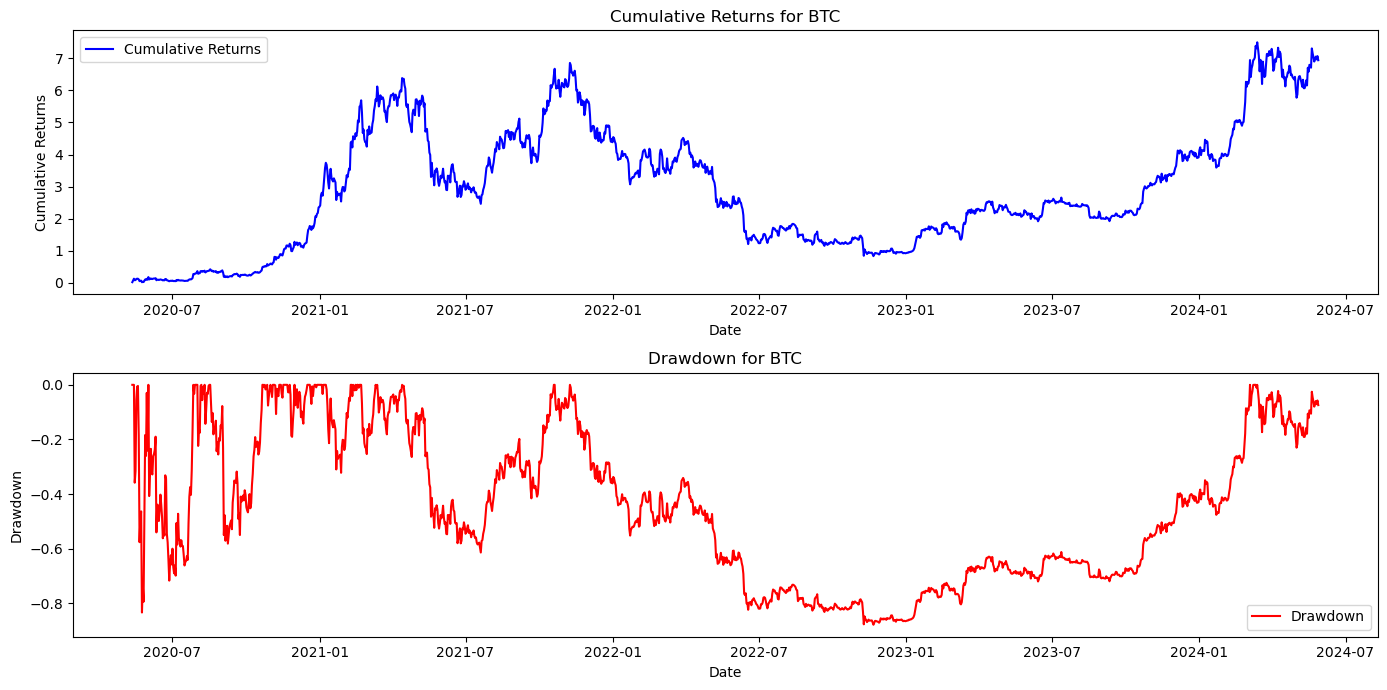

Maximum Drawdown for BTC: -87.81%


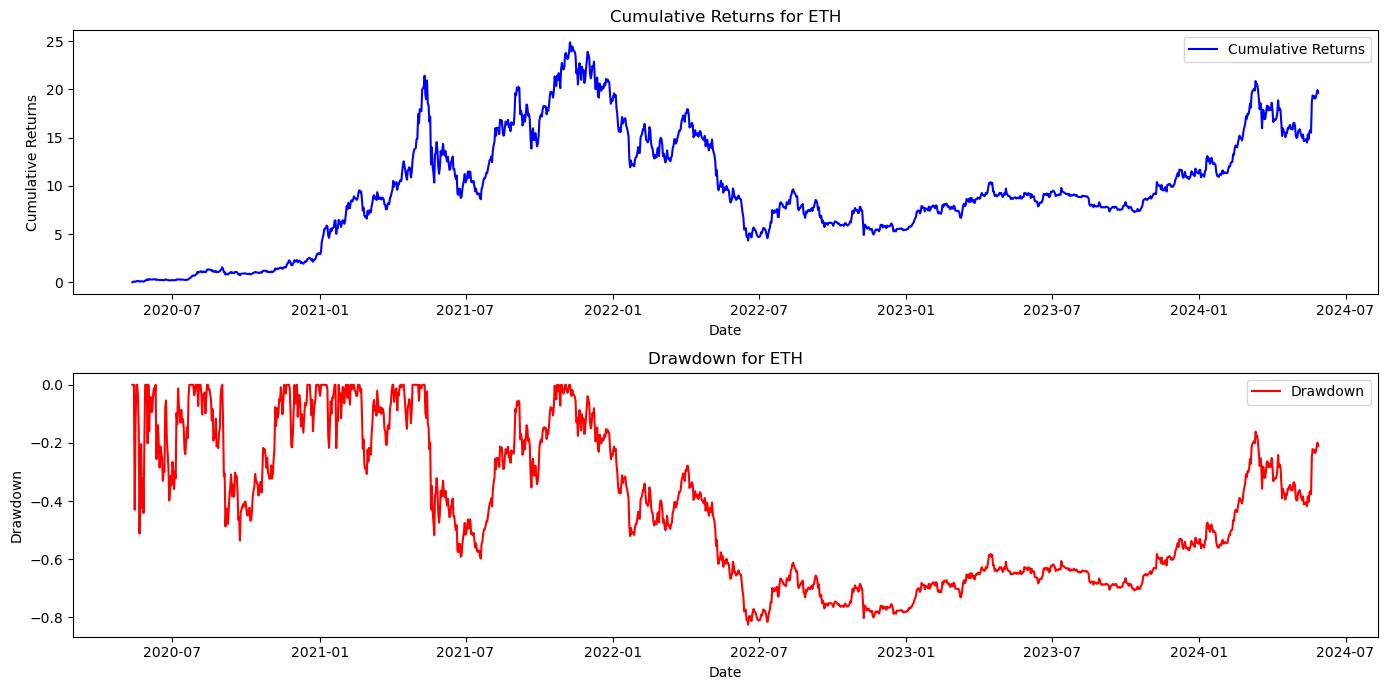

Maximum Drawdown for ETH: -82.54%


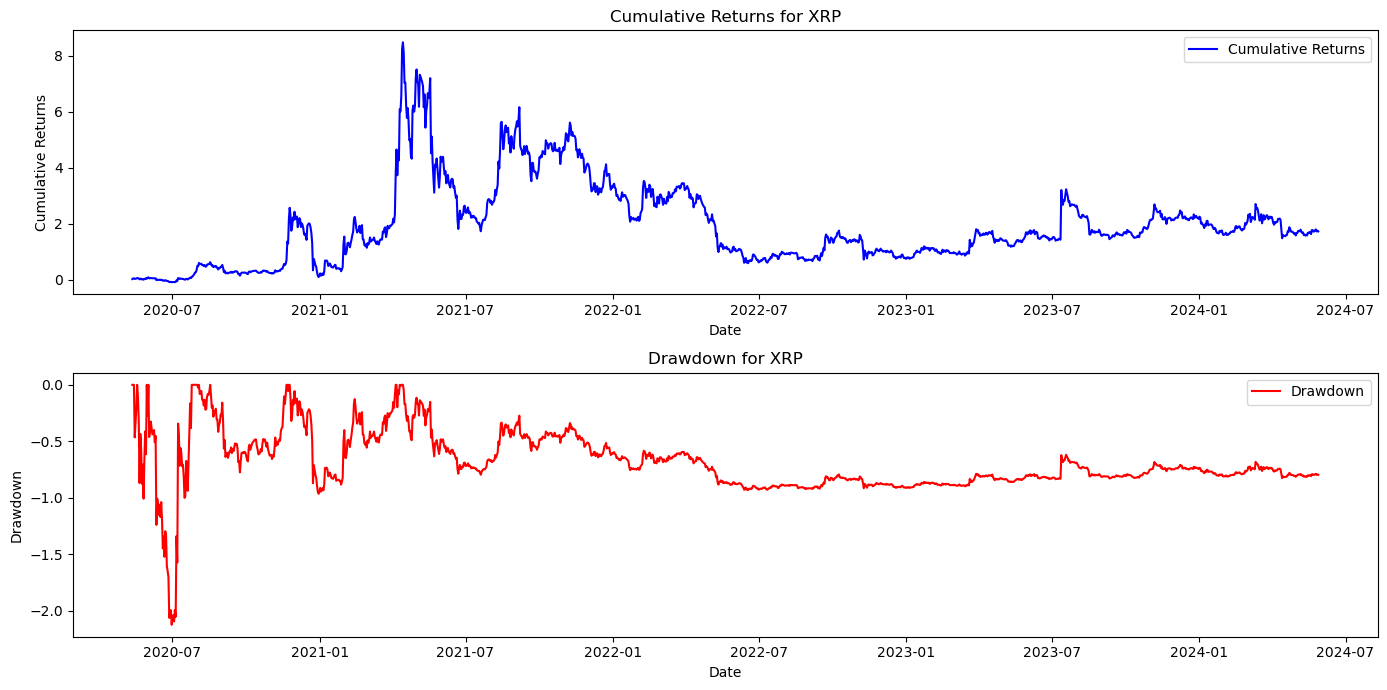

Maximum Drawdown for XRP: -212.41%


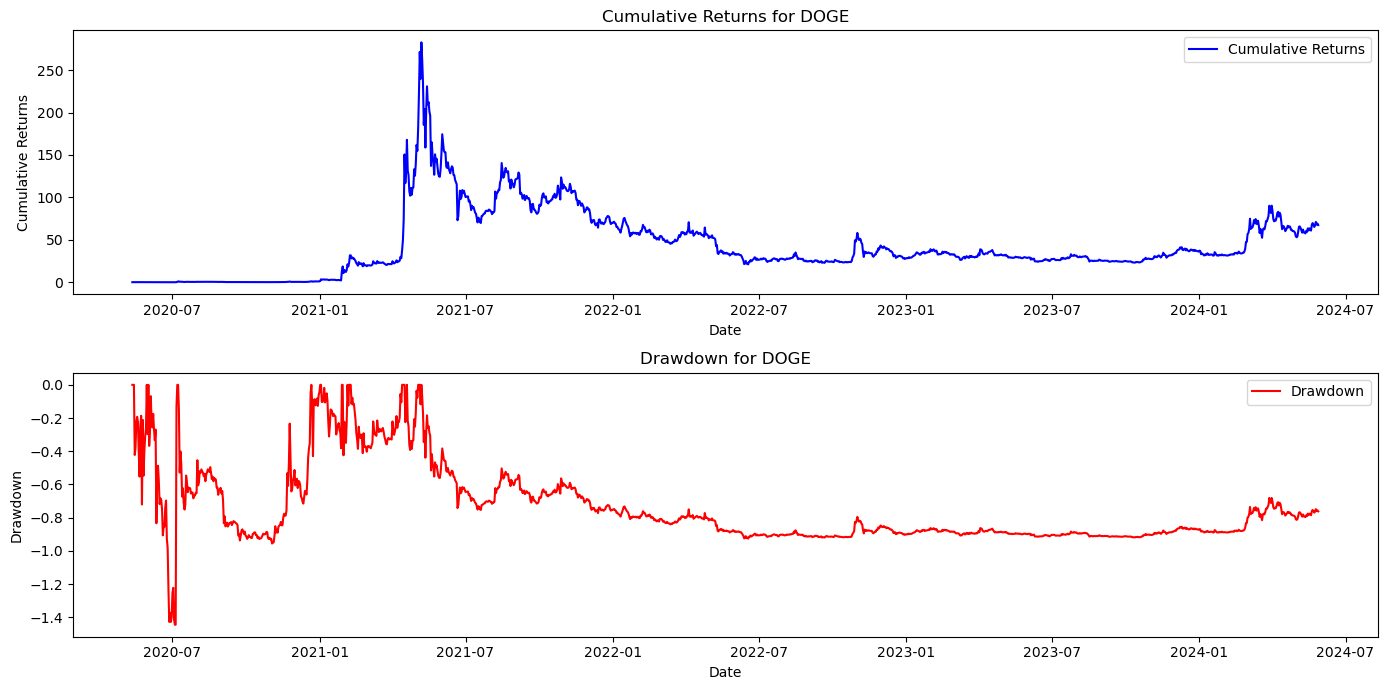

Maximum Drawdown for DOGE: -144.44%


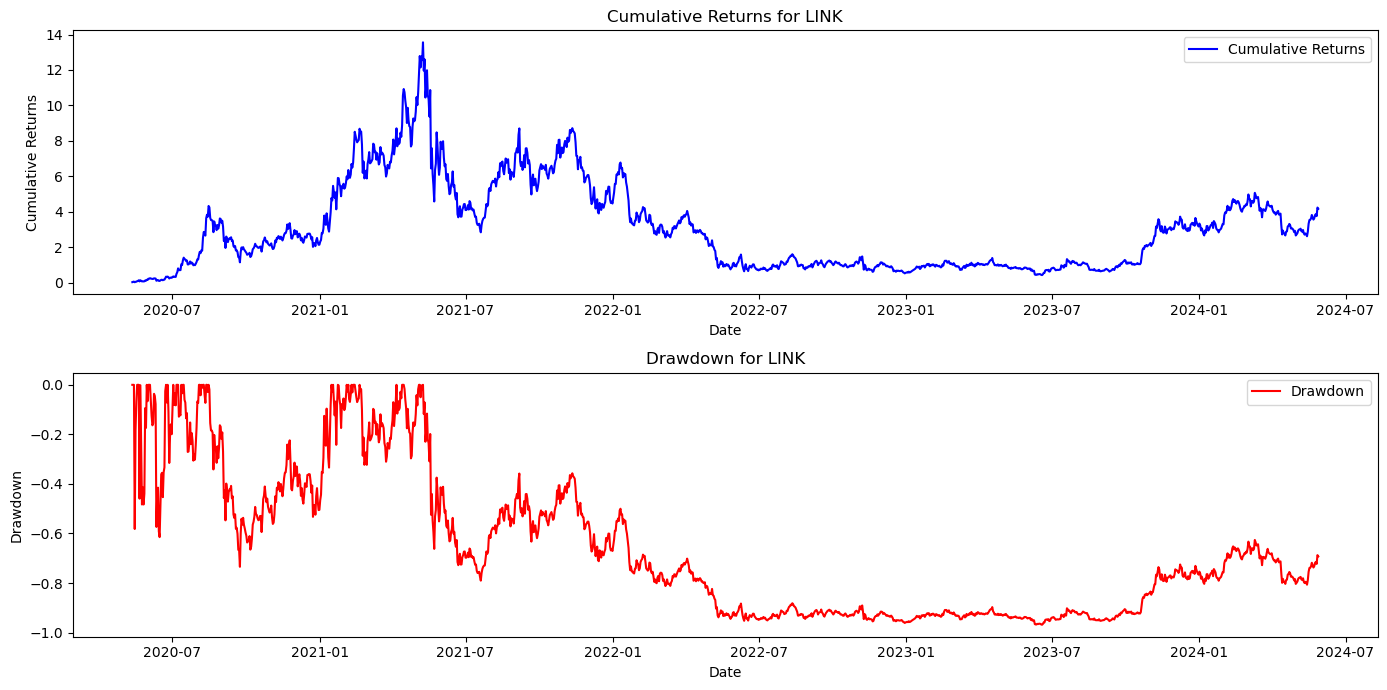

Maximum Drawdown for LINK: -96.84%
Maximum Drawdowns for all assets:
BTC: -87.81%
ETH: -82.54%
XRP: -212.41%
DOGE: -144.44%
LINK: -96.84%


In [38]:
#Checking max drawdown for each asset in portfolio 

# Initialize a dictionary to store the maximum drawdowns
max_drawdowns = {}

# Plotting cumulative returns and drawdowns for each asset
for asset in returns.columns:
    returns_asset = returns[asset]

    # Calculate cumulative returns
    cumulative_returns = (1 + returns_asset).cumprod() - 1

    # Calculate running maximum
    running_max = np.maximum.accumulate(cumulative_returns)

    # Calculate drawdowns
    drawdown = (cumulative_returns - running_max) / running_max

    # Calculate max drawdown
    max_drawdown = drawdown.min()
    max_drawdowns[asset] = max_drawdown

    # Plot cumulative returns and drawdowns
    plt.figure(figsize=(14, 7))

    # Plot cumulative returns
    plt.subplot(2, 1, 1)
    plt.plot(cumulative_returns, label='Cumulative Returns', color='blue')
    plt.title(f'Cumulative Returns for {asset}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()

    # Plot drawdowns
    plt.subplot(2, 1, 2)
    plt.plot(drawdown, label='Drawdown', color='red')
    plt.title(f'Drawdown for {asset}')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Maximum Drawdown for {asset}: {max_drawdown:.2%}")

# Display max drawdowns for all assets
print("Maximum Drawdowns for all assets:")
for asset, max_dd in max_drawdowns.items():
    print(f"{asset}: {max_dd:.2%}")

In [40]:
#Initialize a dictionary to store the maximum drawdowns for each asset
max_drawdowns = {}

# Calculate maximum drawdown for each asset
for asset in returns.columns:
    returns_asset = returns[asset]

    # Calculate cumulative returns
    cumulative_returns = (1 + returns_asset).cumprod() - 1

    # Calculate running maximum
    running_max = np.maximum.accumulate(cumulative_returns)

    # Calculate drawdowns
    drawdown = (cumulative_returns - running_max) / running_max

    # Calculate max drawdown
    max_drawdown = drawdown.min()
    max_drawdowns[asset] = max_drawdown

    print(f"Maximum Drawdown for {asset}: {max_drawdown:.2%}")

# Convert max drawdowns dictionary to a DataFrame
max_drawdowns_df = pd.DataFrame(list(max_drawdowns.items()), columns=['Asset', 'Max Drawdown'])

# Display the DataFrame
print(max_drawdowns_df)

Maximum Drawdown for BTC: -87.81%
Maximum Drawdown for ETH: -82.54%
Maximum Drawdown for XRP: -212.41%
Maximum Drawdown for DOGE: -144.44%
Maximum Drawdown for LINK: -96.84%
  Asset  Max Drawdown
0   BTC     -0.878140
1   ETH     -0.825401
2   XRP     -2.124128
3  DOGE     -1.444445
4  LINK     -0.968443


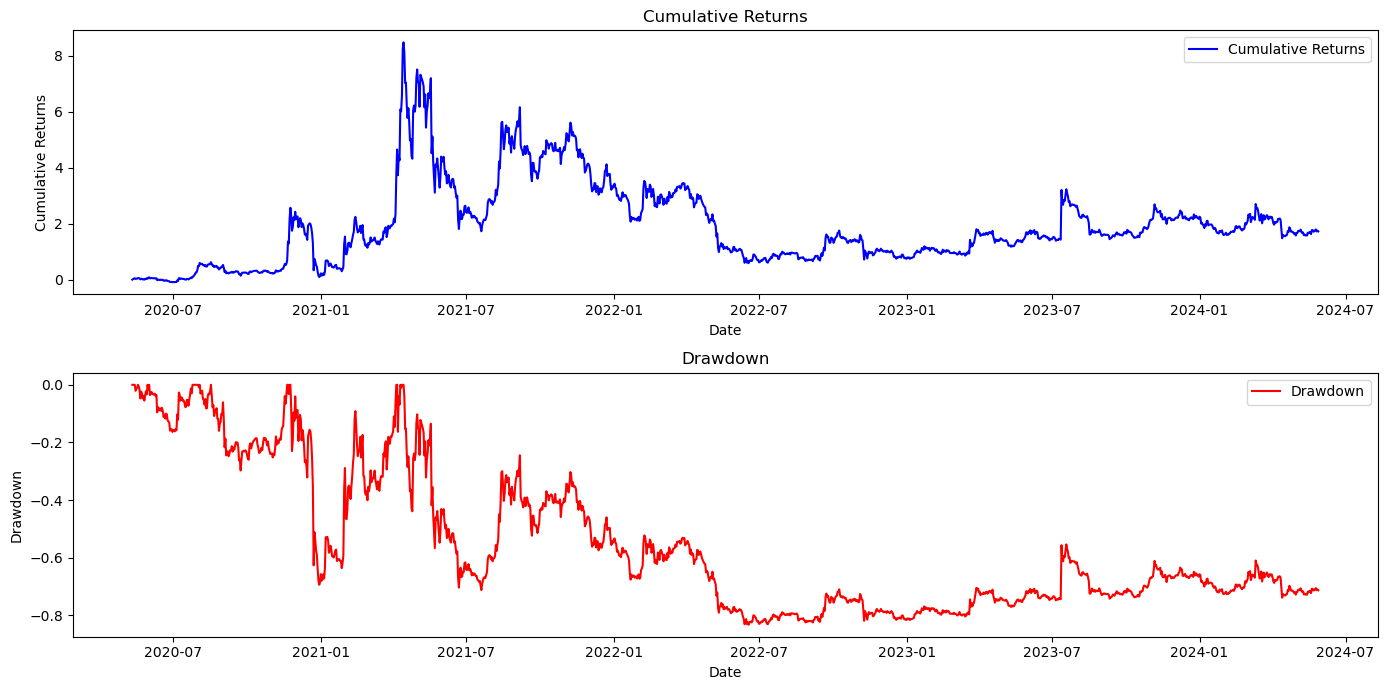

Maximum Drawdown: -83.25%


In [21]:
#XRP Max drawdown using XRP Price

prices = df['XRP']

# Calculate cumulative returns
cumulative_returns = (prices / prices.iloc[0]) - 1

# Calculate running maximum
running_max = np.maximum.accumulate(prices)
running_max[running_max < 0] = 0

# Calculate drawdowns
drawdown = (prices - running_max) / running_max

# Calculate max drawdown
max_drawdown = drawdown.min()

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(cumulative_returns, label='Cumulative Returns', color='blue')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()

# Plot drawdowns
plt.subplot(2, 1, 2)
plt.plot(drawdown, label='Drawdown', color='red')
plt.title('Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Maximum Drawdown: {max_drawdown:.2%}")

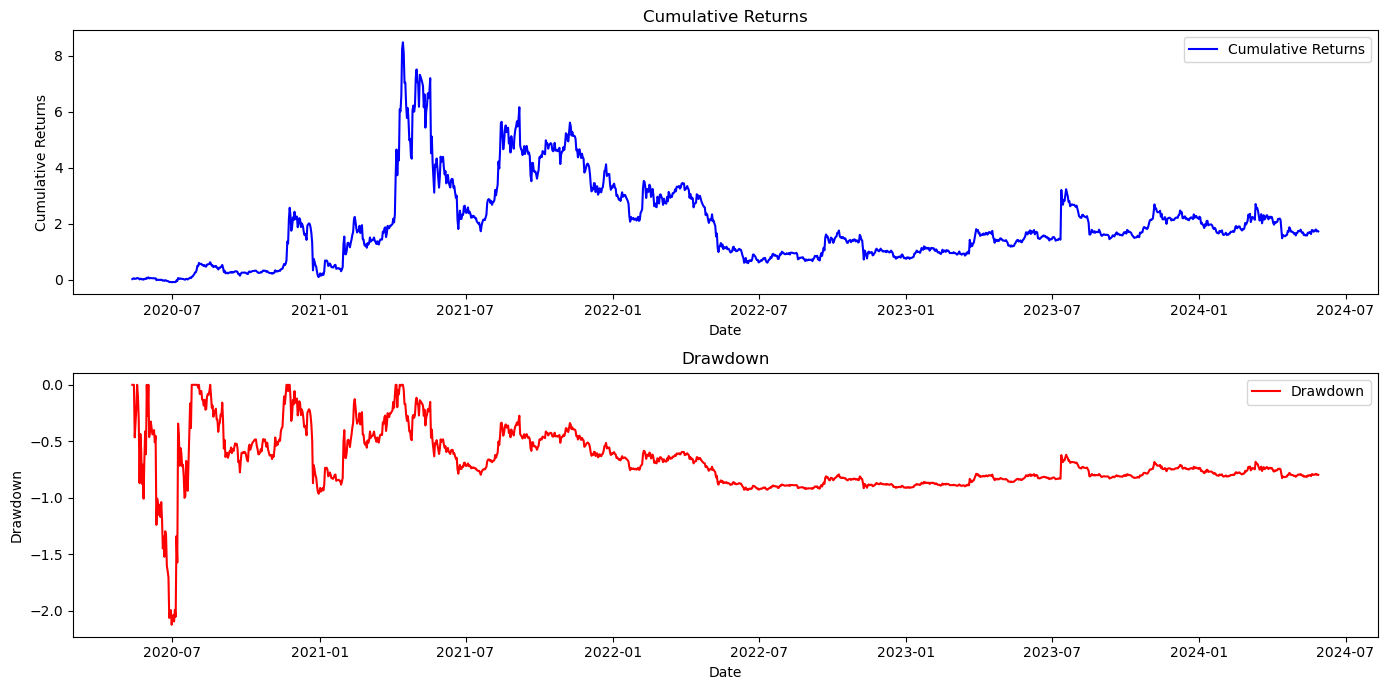

Maximum Drawdown: -212.41%


In [34]:
#XRP Max drawdown using XRP returns

returns_xrp = returns['XRP']

# Calculate cumulative returns
cumulative_returns = (1 + returns_xrp).cumprod() - 1

# Calculate running maximum
running_max = np.maximum.accumulate(cumulative_returns)

# Calculate drawdowns
drawdown = (cumulative_returns - running_max) / running_max

# Calculate max drawdown
max_drawdown = drawdown.min()

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(cumulative_returns, label='Cumulative Returns', color='blue')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()

# Plot drawdowns
plt.subplot(2, 1, 2)
plt.plot(drawdown, label='Drawdown', color='red')
plt.title('Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Maximum Drawdown: {max_drawdown:.2%}")

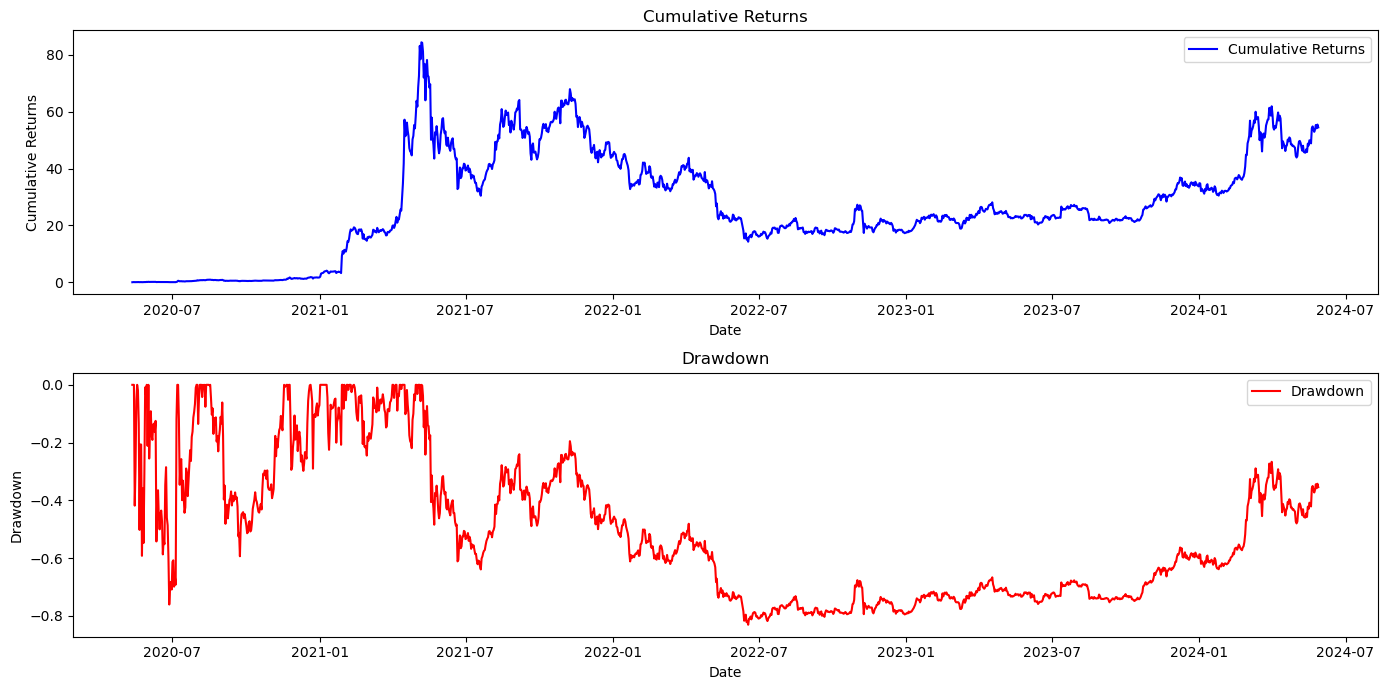

Maximum Drawdown: -83.10%


In [23]:
#Portfolio max drawdown

# Extract weights from the dataframe 'w'
weights = w.iloc[:, 0]

# Calculate the portfolio returns
portfolio_returns = (returns * weights).sum(axis=1)

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod() - 1

# Calculate running maximum
running_max = np.maximum.accumulate(cumulative_returns)
running_max[running_max < 0] = 0

# Calculate drawdowns
drawdown = (cumulative_returns - running_max) / running_max

# Calculate max drawdown
max_drawdown = drawdown.min()

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(cumulative_returns, label='Cumulative Returns', color='blue')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()

# Plot drawdowns
plt.subplot(2, 1, 2)
plt.plot(drawdown, label='Drawdown', color='red')
plt.title('Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Maximum Drawdown: {max_drawdown:.2%}")

In [41]:
#Output dates for maximum drawdown

# Initialize a list to store the results
drawdown_data = []

# Calculate maximum drawdown for each asset
for asset in returns.columns:
    returns_asset = returns[asset]

    # Calculate cumulative returns
    cumulative_returns = (1 + returns_asset).cumprod() - 1

    # Calculate running maximum
    running_max = np.maximum.accumulate(cumulative_returns)

    # Calculate drawdowns
    drawdown = (cumulative_returns - running_max) / running_max

    # Calculate max drawdown and the dates it occurred
    max_drawdown = drawdown.min()
    max_drawdown_end_date = drawdown.idxmin()
    max_drawdown_start_date = (cumulative_returns[:max_drawdown_end_date][cumulative_returns[:max_drawdown_end_date] == running_max[max_drawdown_end_date]]).idxmax()

    # Store the results in the list
    drawdown_data.append([asset, max_drawdown, max_drawdown_start_date, max_drawdown_end_date])

    print(f"Maximum Drawdown for {asset}: {max_drawdown:.2%} from {max_drawdown_start_date} to {max_drawdown_end_date}")

# Convert the results list to a DataFrame
max_drawdowns_df = pd.DataFrame(drawdown_data, columns=['Asset', 'Max Drawdown', 'Start Date', 'End Date'])

# Display the DataFrame
print(max_drawdowns_df)

Maximum Drawdown for BTC: -87.81% from 2021-11-08 00:00:00 to 2022-11-21 00:00:00
Maximum Drawdown for ETH: -82.54% from 2021-11-08 00:00:00 to 2022-06-18 00:00:00
Maximum Drawdown for XRP: -212.41% from 2020-06-01 00:00:00 to 2020-06-30 00:00:00
Maximum Drawdown for DOGE: -144.44% from 2020-06-01 00:00:00 to 2020-07-04 00:00:00
Maximum Drawdown for LINK: -96.84% from 2021-05-09 00:00:00 to 2023-06-19 00:00:00
  Asset  Max Drawdown Start Date   End Date
0   BTC     -0.878140 2021-11-08 2022-11-21
1   ETH     -0.825401 2021-11-08 2022-06-18
2   XRP     -2.124128 2020-06-01 2020-06-30
3  DOGE     -1.444445 2020-06-01 2020-07-04
4  LINK     -0.968443 2021-05-09 2023-06-19


In [45]:
returns.iloc[20:70]

,BTC,ETH,XRP,DOGE,LINK
Date,,,,,
2020-06-01,0.074644,0.069341,0.036189,0.036008,0.060704
2020-06-02,-0.062698,-0.039567,-0.035601,-0.032490,0.001414
2020-06-03,0.013318,0.029341,0.004434,0.008590,0.023683
2020-06-04,0.014904,0.001012,0.006476,0.018583,-0.012851
2020-06-05,-0.013785,-0.013110,-0.004342,-0.013303,-0.012538
2020-06-06,-0.001226,0.002941,-0.004655,-0.003467,-0.007953
2020-06-07,0.010895,0.013375,0.001511,0.007344,0.001683
2020-06-08,0.001295,0.004661,0.001583,-0.008442,0.024804
2020-06-09,0.002478,-0.005678,-0.008627,-0.005805,-0.001723
